# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

Classification or regression?

Our goal is to " to identify students who might need early intervention before they fail to graduate". This means we need to divide students into 2 categories, 

- a) Those students at high risk of failure.
- b) Students who are doing well in the courses.

This means **it is a classification question**.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [77]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
print student_data

Student data read successfully!
    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
5       GP   M   16       U     LE3       T     4     3  services     other   
6       GP   M   16       U     LE3       T     2     2     other     other   
7       GP   F   17       U     GT3       A     4     4     other   teacher   
8       GP   M   15       U     LE3       A     3     2  services     other   
9       GP   M   15       U     GT3       T     3     4     other     other   
10      GP   F   15       U     GT3       T     4     4   teacher    health   
11      GP   F   15 

### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [78]:
# TODO: Calculate number of students
n_students = len(student_data.index)

# TODO: Calculate number of features
n_features = student_data.shape[1] - 1 # Here its total number of columsn - 1 because last column is the prediction.

# TODO: Calculate passing students
n_passed = len(student_data[student_data.passed == 'yes'])
 
# TODO: Calculate failing students
n_failed = n_students - n_passed

# TODO: Calculate graduation rate
grad_rate = n_passed * 100.0 / n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [79]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [80]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [81]:
# TODO: Import any additional functionality you may need here
import sklearn.cross_validation as cv
# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cv.train_test_split(X_all, y_all,stratify=y_all,train_size=num_train,random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

Three supervised learning models that are appropriate for this problem.

- Decision Trees
    - Real-world application: Researching about this topic i found many real world applications. The most interesting was how it was applied in Astronomy where it was used to classify star galactic formations from the data sent by probes. I would imagine that there are many types of variables in classifying a Star or Galaxy based on many different attributes, and a trained classifier can label them with good accuracy as there are billions of star out there and its difficult to classify manually.
    - Strengths
        - Expressiveness of DT - After forming a good model, if we look (i.e in the form of graphs) at decision trees, we can gain deeper insights into the problem.
        - Maximizes information gain. - Decision trees always maximizes information gain and shortest trees. Thus it self corrects itself to have less overfitting.
        - They can get highly accurate in classification especially when there are binary variables involved.
    - Weaknesses
        - ID3 Bias. Restriction biases. We only consider those functions which are represented by a decision tree. This means that it only tries to maximize information gain and other types of functions are left out (like differential functions)
        - Overfitting - A decision tree with large number of levels is prone to overfit and gets complicated. As the depth increases, the complexity grows exponentially. We should be careful to avoid overfitting of train set and prune the tree at the correct location.
    - Why is this a good model for the problem: 
        - This is a good model because there are over 30 features in the input data, and all of them might not be useful. Decision trees automatically select the features with the highest information gain the begining and thus filter out lot of unnecessary noise.

- K-Nearest Neighbors  (GaussianNB)
    - Real-world application: It has been used in ecnomic forcasting to predict how well a product might fit into a given geographical area. It is also used in housing prices prediction and classification of neighbourhoods.
    - Strengths
        - It is easy to understand model with many ways to tune it (the distance function, weights, depth, K val etc)
        - It is good if training data is large. 
        It is robust in noisy data if we tune the distance function to be inverse square of weighted distances
    - Weaknesses
        - Need to determine the value of k. It can be anything
        - Need to define the TYPE of distance. Not all problems can have a "distance" between them
        - High computation cost to determine the distance on each query on multiple training samples.
    - Why is this a good model for the problem:
        - This algorithm may work well in our case because if a students share many of the attributes (i.e distance between them is low), then there is higher chance they are similar. i.e if many students who have been underperforming in test scores fail, a new student who underperforms in test score will need attention in real world as the student has more chance of failure.

- Ensamble: Gradient Boosting
    - Real-world application: Ensable methods in gradient boosing's idea is used in many places and other algorithms too like random forest. One application is spam classification of emails. The classifier is used along with other models. The advantage of this classifier is that it does not overfit the data too much and thus it is hard for someone who is trying to hack a spam classifier to control predictions.
    - Strengths
        - Falls into the ensamble class forming weak classifies (always better than chance prediction p >0.5)
        - This method works really well as it picks out outliers and learns from them
        - This is effective because the error rate of training and test sets seems to always decrease!
        - larger margins are produced which means that in further iterations the confidence in prediction increases.
    - Weaknesses
        - This is a slow algorithm. especially when going through multiple iterations producing many weaklearners. 
    - Why is this a good model for the problem: 
        - This is an ensable methods where with more data and training the prediction is seen to improve more. Thus using this will give a good userstanding to us

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [82]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.


Training 
Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0003 seconds.
F1 score for test set: 0.6452.
Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 0.0011 seconds
Made predictions in 0.0001 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.7258.
Training a DecisionTreeClassifier using a training set size of 300. . .
Trained model in 0.0015 seconds
Made predictions in 0.0002 seconds.
F1 score for training set: 1.0000.
Made predictions in 0.0001 seconds.
F1 score for test set: 0.6838.

Training 
Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0004 seconds
Made predictions in 0.0009 seconds.
F1 score for training set: 0.8252.
Made predictions in 0.0008 seconds.
F1 score for test set: 0.7586.
Training a K

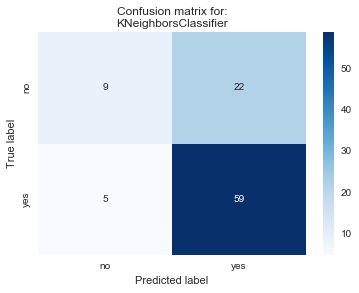

In [83]:
# TODO: Import the three supervised learning models from sklearn
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble

# TODO: Initialize the three models
clf_A = tree.DecisionTreeClassifier(random_state=42)
clf_B = KNeighborsClassifier()
clf_C = ensemble.GradientBoostingClassifier(random_state=42)

# TODO: Set up the training set sizes
# not needed

# TODO: Execute the 'train_predict' function for each classifier and each training set size

for clf in [clf_A,clf_B,clf_C]:
    print "\nTraining ".format(clf.__class__.__name__)
    for n in [100,200,300]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        
def confusionMatrix(model):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    %matplotlib inline

    # Compute confusion matrix for a model
    cm = confusion_matrix(y_test.values, model.predict(X_test))

    # view with a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

#draw confusion matrix for best model
confusionMatrix(clf_B)


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - DecisionTreeClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |      0.0010             |       0.0004       |    1.0000         |    0.6452       |
| 200               |        0.0015          |         0.0001         |   1.0000       |    0.7258        |
| 300               |       0.0017            |        0.0001        |  1.0000         |    0.6838      |

** Classifer 2 - K nearest neighbours**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0004            |          0.0008        |     0.8252      |   0.7586       |
| 200               |     0.0005             |       0.0012         |      0.8097      |    0.7857      |
| 300               |       0.0006            |     0.0016           |    0.8538       |     0.8138     |

** Classifer 3 - Ensemble gradient boosting**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |      0.0401            |        0.0004         |     1.0000      |     0.7500     |
| 200               |      0.0492           |         0.0003        |      0.9924     |      0.7313     |
| 300               |      0.0623           |         0.0007       |    0.9781        |     0.7463      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

Out of the above 3 algorithms we can eliminate using a DecisionTreeClassifier (using default parameters as indicated in question) because it performs worse in all aspects.

The choice is between K nearest neighbours and Ensemble gradient boosing.

Comparision

| K nearest neighbours(KNN) | Ensemble gradient boosting |
| :---------------: | :---------------------: |
| Training time faster               |     Training time slower            |
| Prediction time is 2x slow | Prediction time Fastest |
| F1 test score highest at **0.81 highest** | F1 test score highest with 0.75

I go with **K nearest neighbours**. The reason is because

- The training time is lower but the prediction time is higher. This helps for a fast training is done one time only. But the prediction time is only linearly lower
- This model always performs better in all the training set sizes.
- This makes more intutive sense because k-nearest algorithm captures similarity distance and similar students group would perform same way in real-world

**Another important point** - After drawing confusition matrix it appears the the most dangerous part in our algorithm is to predict a student doent *not* need attention while in reality the student needs. i.e P(false) while actual is true. This is dangerous because the student will fail and we didnt provide extra attention. However providing extra attention to passing students is not a problem as it will only help them.

This is least in KNN (5 students) and thus another plus point

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

# **Answer: **

~~Ensable learners use the concept of "weak learners" where in the simple rule is to find a prediction at each stage which has a accuracy better than chance i.e p > 0.5. This is very simple concept but when it is iterated over several of the parameters it produces a powerful classifier. In the training stage we take known data with known labels and produce a hypothesis which gives us p>0.5, then we repeat it for several iteration. Then finally we combine the models  individually according to thier weights and produce a final model.~~

~~**UPDATE 1:**~~

~~Ensemble gradient boosing algorithms work on a simple concept that the prediction at each stage is *slightly better than chance*. The algorithm works as follows~~

~~concepts:~~
- ~~Ensemble learners: a collection of models which predict a certain part of the data~~
- ~~weak learners: A model who's prediction accuracy is >50%~~

~~Algorithm~~

~~0. initialize each data with equal weights~~
~~1. construct a (weak)model which is better than chance.~~
~~2. Increase the weights for those data which predictions went wrong.~~
~~3. Train next model using samples drawn according to updated weight distribution. repeat from steps 1,2,3 untill we are satisfied with final prediction.~~
~~4. we can combine the hypothesis at last bsaed on weights on how many dataset it got right


~~In this way the algorithm learns models for data which are "hard" to learn and thus the ensemble of these models produces a good model which is good a learning different parts of the data.~~

~~**explanation interms of school data** - Imagine a set of features could explain correctly >50% of the time if student passes or fails. Now the algoritmn will increase weights on those students which it missed in prediction. Then we build another model which describese these outlier students. repeating the above steps produces a robust algorithm which can predict different types of students who are prone to failure.~~


# Update 2:

After implementing the sugession to split the train-test split evenly, I see that K-nearest neighbour is better prediction algorithm.

K-nearest neighbours(KNN), it is a classification or regression technique. KNN for our case is a classification with output a class membership of student being pass being "yes" or "no". The KNN is a lazy algorithm where function is only approximated locally and all computations is deferred untill classification.

In KNN we define a *distance function* which produces a output of distance between 2 data points. This can be many times of functions from simple cartition coordinate distance to a specialized function which is domain specific such as driving distance in case of a housing example.

Given a new training example, KNN performs as follows.

1. Finds K nearest neighbours through the *distance function*
2. using the known class of these K nearest neighbours calculate the predicted class of the New training example. This can be done in many ways (weighted avg, log func, inverse exponential functions, custom functions etc).

**explanation in-terms of school data** The algorithm tries to group together similar students who are "close" to each other. In this case close can be defined as a simple subtraction because we used *pandas.get_dummy()* when we converted these *categorical* datas into differnt columns. Thus the difference captures the differences correctly as it is a binary variable.

Intutively, students with similar charecteristics tend to either pass or fail. i.e if a student has failed in many of the subjects he/she is more prone to fail at the end and vice-versa.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [84]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn import grid_search
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.neighbors import DistanceMetric
# TODO: Create the parameters list you wish to tune
parameters = {
                'weights' : ['uniform','distance'],
                'leaf_size' : [5,15,30,45]
             }

# TODO: Initialize the classifier
clf = KNeighborsClassifier()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = grid_search.GridSearchCV(clf,parameters)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0075 seconds.
Tuned model has a training F1 score of 0.8539.
Made predictions in 0.0027 seconds.
Tuned model has a testing F1 score of 0.8138.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

~~The final F1 train score is 0.8406 and F1 test score is 0.8000. This is an improvement of 0.02 from the untuned model which is an *improvement of 2.5%* (0.02/0.78)~~

**Update 2:**

The final training score is 0.8539 and test score is 0.8138. There is no improvement from the untuned model.

Even after trying to fit the data to many parameters, I could not increase the prediction accuracy over the default values for parameters. It either decreased or remained the same amount of test-set F1 score.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.